# _LDC1-1 Merging Massive Black Hole Binary Tutorial_

The data files and codes used in this tutorial can be found on the LISA Data Challenge website:
* files: https://lisa-ldc.lal.in2p3.fr/file
* codes: https://lisa-ldc.lal.in2p3.fr/code (available soon)

### 1. Importing needed packages

In [2]:
import numpy as np
import copy
import sys, os, re
from scipy.interpolate import InterpolatedUnivariateSpline as spline

import LISAConstants as LC

from LISAhdf5 import LISAhdf5,ParsUnits,Str
from optparse import OptionParser
import GenerateFD_SignalTDIs as GenTDIFD
import LW_simple as LW
import pyFDresponse as FD_Resp
import pyIMRPhenomD

import tdi, Cosmology
import matplotlib.pyplot as plt
import pandas as pd

# Set the path where the MLDC scripts are located
script_path = "/Users/qbaghi/Codes/MLDC/software/LDCpipeline/scripts/"

### 2. Reading hdf5 data file

#### 2.1 Load noiseless data

In [3]:
# Specify the hdf5 file path
hdf5_path = "/Users/qbaghi/Codes/data/LDC/LDC1-1_MBHB_v1_1_FD_noiseless.hdf5"
# Open the file with the dedicated LISAhdf5 module
FD5 =  LISAhdf5(hdf5_path)
# Number of sources
Nsrc = FD5.getSourcesNum()
# Types of sources
GWs = FD5.getSourcesName()
print ("Found %d GW sources: " % Nsrc, GWs)
# Get source parameters
p = FD5.getSourceParameters(GWs[0])
# Get the time delay interferometry data
td = FD5.getPreProcessTDI()
# Sampling time
del_t = float(p.get("Cadence"))
# Observation duration
Tobs = float(p.get("ObservationDuration"))
# Display the source parameters
p.display()

Found 1 GW sources:  ['MBHB-0']
	Approximant IMRPhenomD [ModelName]
	AzimuthalAngleOfSpin1 0.6171792478977071 [Radian]
	AzimuthalAngleOfSpin2 4.75979656623224 [Radian]
	Cadence 10.0 [Seconds]
	CoalescenceTime 25135000.0 [Second]
	Distance 60.42017466175677 [Gpc]
	EclipticLatitude -0.5256036732051035 [Radian]
	EclipticLongitude 1.1637 [Radian]
	InitialAzimuthalAngleL 0.30782038099413395 [Radian]
	InitialPolarAngleL 1.2498 [Radian]
	Mass1 2803843.776 [SolarMass]
	Mass2 285210.246 [SolarMass]
	ObservationDuration 41943040.0 [Seconds]
	PhaseAtCoalescence 2.596553404898615 [Radian]
	PolarAngleOfSpin1 0.0 [Radian]
	PolarAngleOfSpin2 0.0 [Radian]
	Redshift 6.1178 [dimensionless]
	Spin1 0.8986046314480332 [MassSquared]
	Spin2 0.9465882372512956 [MassSquared]



#### 2.2 Load noisy data

In [4]:
# Specify the hdf5 file path for noisy data
hdf5_path_noise = "/Users/qbaghi/Codes/data/LDC/LDC1-1_MBHB_v1_1_FD.hdf5"
# Open the file with the dedicated LISAhdf5 module
FD5_noise =  LISAhdf5(hdf5_path_noise)
# Get the time delay interferometry data
td_noise = FD5_noise.getPreProcessTDI()

#### 2.3 Plot de TDI data in the time domain

<Figure size 432x288 with 0 Axes>

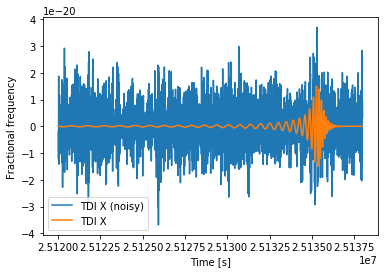

In [5]:
df1 = pd.DataFrame(td,columns=['Time','TDI X', 'TDI Y', 'TDI Z'])
df1_noise = pd.DataFrame(td_noise,columns=['Time','TDI X (noisy)', 'TDI Y (noisy)', 'TDI Z (noisy)'])
plt.figure(1)
ax = df1_noise.iloc[2512000:2513800].plot(x = 'Time',y = ['TDI X (noisy)'])
df1.iloc[2512000:2513800].plot(x = 'Time',y = ['TDI X'],ax=ax)

plt.xlabel("Time [s]")
plt.ylabel("Fractional frequency")
plt.legend(loc='best')
plt.show()

#### 2.4 Plot the TDI data in the frequency domain

Define tapering window to decrease spectral leakage:

In [6]:
def Window(tm):

    xl = 1000.0
    ind_r = np.argwhere(tm[-1]-tm <= 1000.0)[0][0]
    xr = tm[ind_r]
    # print (xr)
    kap = 0.005
    winl = 0.5*(1.0 + np.tanh(kap*(tm-xl)))
    winr = 0.5*(1.0 - np.tanh(kap*(tm-xr)))
    # plt.plot(tm, winl)
    # plt.plot(tm, winr)
    # plt.grid(True)
    # plt.show()
    return (winl*winr)

Noiseless data

In [7]:
# Number of points in the time series
Npts = 2**22
# Tapering window to mitigate leakage
wind = Window(td[:Npts,0])
# Create frequency data matrix
td_freq = np.zeros(np.shape(td[:Npts,:]),dtype = np.complex128)
# Take discrete Fourier transform of the noiseless data
td_freq[:,1:] = np.array( [ np.fft.fft(td[:Npts,i]*wind,axis = 0) for i in range(1,4)] ).T
# Compute corresponding frequency vector
freq = np.fft.fftfreq(Npts)/del_t
td_freq[:,0] = freq
# Store the amplitude modulus in data frame (positive frequencies)
td_freq_plot = np.zeros(np.shape(td_freq[freq>0,:]),dtype = np.float64) 
td_freq_plot[:,0] = freq[freq>0]
# Apply right normalization to get amplitudes 
td_freq_plot[:,1:] = np.abs(td_freq[freq>0,1:])*2/np.sum(wind)
df2 = pd.DataFrame(td_freq_plot,columns=['freq','TDI X', 'TDI Y', 'TDI Z'])

Noisy data

In [8]:
# Create frequency data matrix
td_noise_freq = np.zeros(np.shape(td_noise[:Npts,:]),dtype = np.complex128)
# Take discrete Fourier transform of the noiseless data
td_noise_freq[:,1:] = np.array( [ np.fft.fft(td_noise[:Npts,i]*wind,axis = 0) for i in range(1,4)] ).T
# Corresponding frequency vector
td_noise_freq[:,0] = freq
# Store the amplitude modulus in data frame (positive frequencies)
td_freq_plot = np.zeros(np.shape(td_noise_freq[freq>0,:]),dtype = np.float64) 
td_freq_plot[:,0] = freq[freq>0]
# Apply right normalization to get amplitudes 
td_freq_plot[:,1:] = np.abs(td_noise_freq[freq>0,1:])*2/np.sum(wind)
df2_noise = pd.DataFrame(td_freq_plot,columns=['freq','TDI X (noisy)', 'TDI Y (noisy)', 'TDI Z (noisy)'])

Plots

<Figure size 432x288 with 0 Axes>

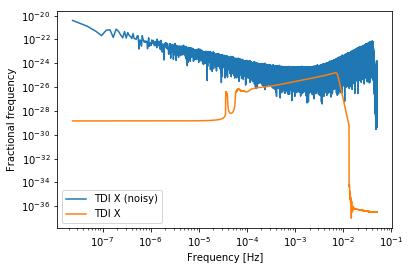

In [9]:
# Plot the Fourier amplitudes
plt.figure(3)
ax2 = df2_noise.plot(x = 'freq',y = ['TDI X (noisy)'],logx=True,logy=True)
df2.plot(x = 'freq',y = ['TDI X'],logx=True,logy=True,ax = ax2)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Fractional frequency")
plt.legend(loc='best')

### 3. Generate the signal in the frequency domain using PhemomD: fast generation

#### 3.1 Duplicate the hdf5 file

In [10]:
hdf5_path_FD = hdf5_path[:-5] + "_FD.hdf5"
FD5_FD = LISAhdf5(hdf5_path_FD)
FD5_FD.addSource(GWs[0], p, overwrite=True)

#### 3.2 Computing the X, Y, Z in frequency domain using approximate response function

In [11]:
dTDI_FD = GenTDIFD.ComputeMBHBXYZ_FD(p)
dTDI_FD = np.array(dTDI_FD).T
dTDI_FD[:,1:] = dTDI_FD[:,1:]*2/Tobs

#### 3.3 Comparing to simulated data

<Figure size 432x288 with 0 Axes>

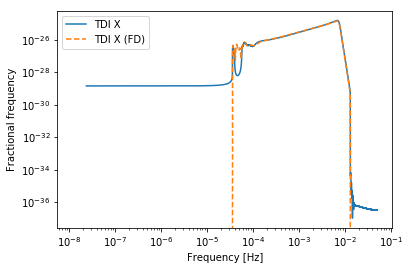

In [12]:
df3 = pd.DataFrame(np.abs(dTDI_FD),columns=['f','TDI X (FD)', 'TDI Y (FD)', 'TDI Z (FD)'])
plt.figure(4)
ax3 = df2.plot(x = 'freq',y = 'TDI X',logx=True,logy=True)
df3.plot(x = 'f', y = 'TDI X (FD)',ax = ax3, logx=True,logy=True,style='--')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Fractional frequency")
plt.legend(loc='best')

### 4. Compute signal-to-noise ratio

#### 4.1 Consider X channel only

In [13]:
# Consider Fourier-transformed TDI X channel only
Xdf = td_freq[:,1]*del_t
# Consider positive frequencies only
inds = np.where(freq>0)[0]

#### 4.2 Compute corresponding theoretical noise power spectral density


In [14]:
Sx = tdi.noisepsd_X(freq[inds], model='Proposal', includewd=None)

#### 4.3 Compute SNR

In [18]:
# Frequency resolution
df = 1/Tobs
# SNR 
SNR_X = (4.0*df) * np.sum(np.abs(Xdf[inds])**2/Sx)
print("Computed SNR is " + str(np.sqrt(SNR_X)))

Computed SNR is 274.3158858351279
